In [2]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
# from detection_msgs.msg import BoundingBox, BoundingBoxes

In [3]:

bag = rosbag.Bag('bott_first_static_short_1.bag')



bag.get_type_and_topic_info()[1]

{'/camera/color/camera_info': TopicTuple(msg_type='sensor_msgs/CameraInfo', message_count=104, connections=1, frequency=12.653722229596823),
 '/camera/color/image_raw': TopicTuple(msg_type='sensor_msgs/Image', message_count=103, connections=1, frequency=12.5294550799016),
 '/camera/color/image_raw/compressed': TopicTuple(msg_type='sensor_msgs/CompressedImage', message_count=103, connections=1, frequency=12.495692069355895),
 '/camera/color/image_raw/theora': TopicTuple(msg_type='theora_image_transport/Packet', message_count=104, connections=1, frequency=12.659756723310494),
 '/camera/color/metadata': TopicTuple(msg_type='realsense2_camera/Metadata', message_count=104, connections=1, frequency=12.660788510125784),
 '/camera/realsense2_camera_manager/bond': TopicTuple(msg_type='bond/Status', message_count=17, connections=1, frequency=2.000017643130492),
 '/diagnostics': TopicTuple(msg_type='diagnostic_msgs/DiagnosticArray', message_count=36, connections=1, frequency=7476.477718360071),
 

In [345]:
# images = []
states = []
estimates = []
innovations = []
predictions = []
E = estimator()
for topic, msg, t in bag.read_messages():
    # if topic == '/yolov5/image_out':
    #     images.append(E.unpack_image(msg))
    #     print('Unpacked image: ', len(images))
    if topic == '/yolov5/detections':
        states.append(E.state_from_detections(msg))
        E.increment_filter()
        estimates.append(E.state_estimate)
        innovations.append(E.innovation)
        predictions.append(E.state_prediction)
        print('Extracted state: ', len(states))
        print('K: ', np.linalg.norm(E.K))
        print('P: ', np.linalg.norm(E.P))
        print('P_pred: ', np.linalg.norm(E.P_pred))
        # print('P: ', np.linalg.norm(E.P))

states_disp = []
ests_disp = []
preds_disp = []
inn_disp = []
for k in range(len(states)):
    state_reshaped = np.zeros((num_materials, num_volumes))
    est_reshaped = np.zeros((num_materials, num_volumes))
    preds_reshaped = np.zeros((num_materials, num_volumes))
    inn_reshaped = np.zeros((num_materials, num_volumes))
    for i in range(num_volumes):
        for j in range(num_materials):
            state_reshaped[j, i] = states[k][i*num_materials + j]
            est_reshaped[j, i] = estimates[k][i*num_materials + j]
            inn_reshaped[j, i] = innovations[k][i*num_materials + j]
            preds_reshaped[j, i] = predictions[k][i*num_materials + j]
    states_disp.append(state_reshaped)
    ests_disp.append(est_reshaped)
    inn_disp.append(inn_reshaped)
    preds_disp.append(preds_reshaped)

1.0
[[1.   0.   0.25 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.25]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]
Extracted state:  1
K:  4.246007968179443
P:  4.246007968179444
P_pred:  11.490825144435886
1.0
[[1.   0.   0.25 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.25]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]
Extracted state:  2
K:  4.00637908574301
P:  4.00637908574301
P_pred:  9.772181369725358
1.0
[[1.   0.   0.25 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.25]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]
Extracted state:  3
K:  3.980888915248346
P:  3.980888915248346
P_pred:  9.59825031324092
1.0
[[1.   0.   0.25 ... 0.   0. 

In [198]:
1279/(1281/12)

11.981264637002342

In [344]:
class estimator:

    def __init__(self):
        self.num_materials = 2
        self.num_volumes = 24
        self.im_width = 1280
        self.sigma_process = 1
        self.sigma_measurement = 1
        self.num_speeds = 3
        self.speed = 1.75
        
        self.state_dim = self.num_materials * self.num_volumes
        self.state_measurement = np.zeros((self.state_dim))
        self.state_prediction = np.zeros((self.state_dim))
        self.state_estimate = np.zeros((self.state_dim))
        self.innovation = np.zeros((self.state_dim))
        
        self.A = self.generate_a_matrix()
        self.A_lin = self.A[0]
        self.P = np.eye(self.state_dim) * self.sigma_process
        self.P_pred = np.eye(self.state_dim) * self.sigma_measurement
        self.R = np.eye(self.state_dim) * self.sigma_measurement
        self.Q = np.eye(self.state_dim) * self.sigma_process
        
        self.K = np.zeros((self.state_dim, self.state_dim))
    
    def unpack_image(self, msg):
        image = np.zeros((msg.height, msg.width, 3), dtype=np.uint8)        
        
        for row in range(msg.height):
            for i in range(msg.width):
                image[row, i, 2] = int(msg.data[msg.step*row + 3*i])
                image[row, i, 1] = int(msg.data[msg.step*row + 3*i + 1])
                image[row, i, 0] = int(msg.data[msg.step*row + 3*i + 2])
        return image
    
    def state_from_detections(self, msg):
        self.state_measurement = np.zeros((self.state_dim))
        for obj_id in range(len(msg.bounding_boxes)):
            # first left-right flip
            start_vol = int(msg.bounding_boxes[obj_id].xmin/(self.im_width/self.num_volumes))
            end_vol = int(msg.bounding_boxes[obj_id].xmax/((self.im_width+1)/self.num_volumes))
            span = 1 + end_vol - start_vol
            # print('class: ', msg.bounding_boxes[obj_id].Class)
            # print('start_vol: ', start_vol, ', xmin: ', msg.bounding_boxes[obj_id].xmin)
            # print()
            # print()
            # print('end_vol: ', end_vol, ', xmax: ', msg.bounding_boxes[obj_id].xmax)
            # print('span: ', span)

            inds = np.zeros((span), dtype = int)
            for ind in range(span):
                inds[ind] = int((start_vol+ind)*self.num_materials)
            
                # if msg.bounding_boxes[obj_id].Class == 'Bottles':
                #     inds[ind] += 1
                if msg.bounding_boxes[obj_id].Class == 'Cans':
                    inds[ind] += 1
            # print('inds: ', inds)
            # print('state: ', self.state)
            self.state_measurement[inds] += 1/span
            # print('state: ', self.state)
            # print('sum of state: ', np.sum(self.state), '\n\n')
        return self.state_measurement

    def get_state_prediction(self):        
        self.linearize_A()
        return self.A_lin @ self.state_estimate

    def generate_a_matrix(self):
        A = np.zeros((self.state_dim, self.state_dim, self.num_speeds))
        for speed in range(self.num_speeds):
            for i in range((self.num_volumes-speed)*self.num_materials):
                A[i, i+(speed * self.num_materials), speed] = 1
            for i in range(self.num_materials):
                A[-i, -i, speed] = 1
        return A

    def cov_prediction(self):
        return self.A_lin @ self.P @ self.A_lin.T + self.Q

    def correction(self):
        self.innovation = self.state_measurement - self.state_prediction
        S = self.P_pred + self.R
        self.K = self.P_pred @ np.linalg.inv(S)
        self.state_estimate = self.state_prediction + self.K @ self.innovation
        # print((self.K))
        self.P = (np.eye(self.state_dim) - self.K) @ self.P_pred

    def increment_filter(self):
        self.state_prediction = self.get_state_prediction()
        self.P_pred = self.cov_prediction()

        
        # self.state_from_detections(msg)
        self.correction()

    def linearize_A(self):
        floor = np.floor(self.speed)
        print(floor)
        ceil = floor + 1
        ratio = self.speed - floor
        self.A_lin = self.A[:, :, int(floor)] * (1-ratio) + self.A[:, :, int(ceil)] * ratio
        print(self.A_lin)

        
        

E = estimator()

In [121]:
for topic, msg, t in bag.read_messages():
    if topic == '/yolov5/detections':
        message = msg
        # print('\n\n\n')
        # print(len(msg.bounding_boxes))

In [259]:
# print(message)
im_mask = np.ones_like(images[0], dtype=np.uint8)
# im_lines = np.zeros_like(images[0], dtype=np.uint8)


for line in range(E.num_volumes):
    col = int(line*E.im_width/E.num_volumes)
    im_mask[:, col, :] = 0
    im_lines[:, col, :] = 255
        

IndexError: list index out of range

In [277]:
E.A.T

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [243]:
plt.imshow(images[1]*im_mask)
plt.plot(vol_ids, state_reshaped[0])
plt.plot(vol_ids, state_reshaped[1])

In [232]:
num_materials = 2
num_volumes = 24
vol_ids = np.zeros((num_volumes))
im_width = 1280
for i in range(num_volumes):
    vol_ids[i] = i * (im_width/num_volumes) + 0.5 * (im_width/num_volumes)
state_reshaped = np.zeros((num_materials, num_volumes))
for i in range(num_volumes):
    for j in range(num_materials):
        state_reshaped[j, i] = E.state[i*num_materials + j]

In [313]:
states_disp = []
ests_disp = []
preds_disp = []
inn_disp = []
for k in range(len(states)):
    state_reshaped = np.zeros((num_materials, num_volumes))
    est_reshaped = np.zeros((num_materials, num_volumes))
    preds_reshaped = np.zeros((num_materials, num_volumes))
    inn_reshaped = np.zeros((num_materials, num_volumes))
    for i in range(num_volumes):
        for j in range(num_materials):
            state_reshaped[j, i] = states[k][i*num_materials + j]
            est_reshaped[j, i] = estimates[k][i*num_materials + j]
            inn_reshaped[j, i] = innovations[k][i*num_materials + j]
            preds_reshaped[j, i] = predictions[k][i*num_materials + j]
    states_disp.append(state_reshaped)
    ests_disp.append(est_reshaped)
    inn_disp.append(inn_reshaped)
    preds_disp.append(preds_reshaped)

/tmp/ipykernel_380568/515096968.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex='col')


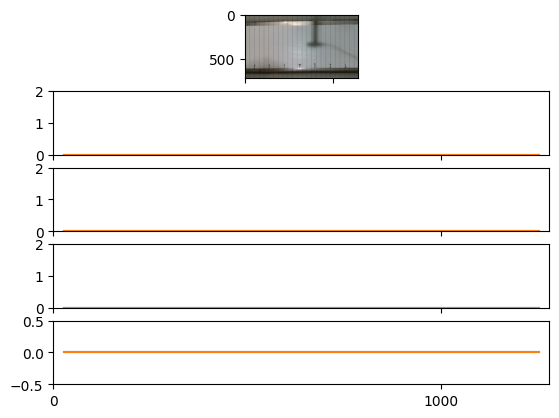

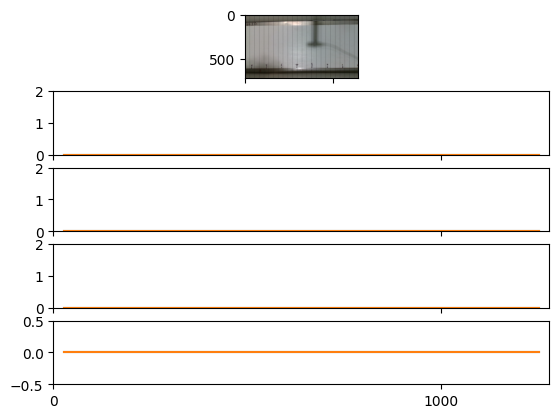

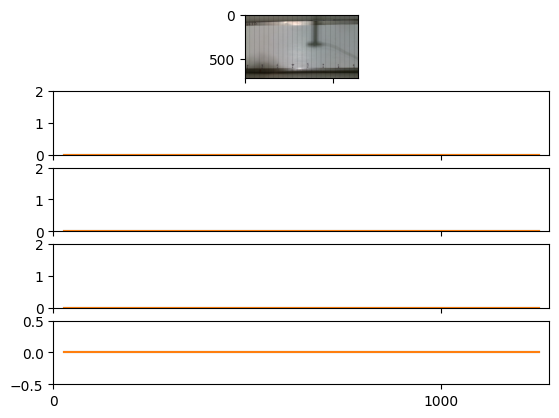

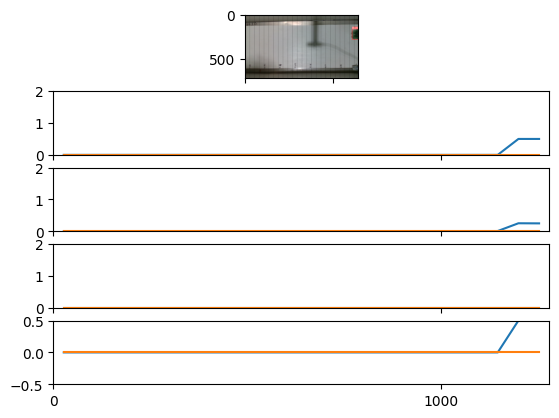

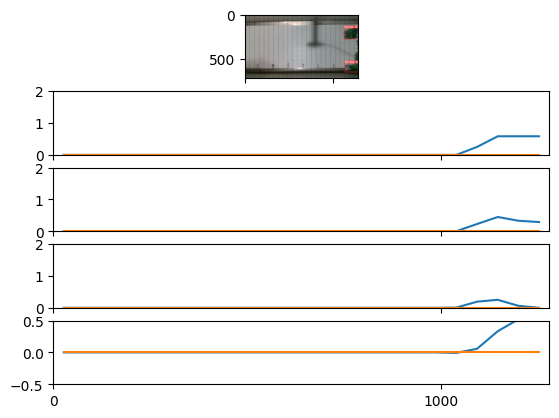

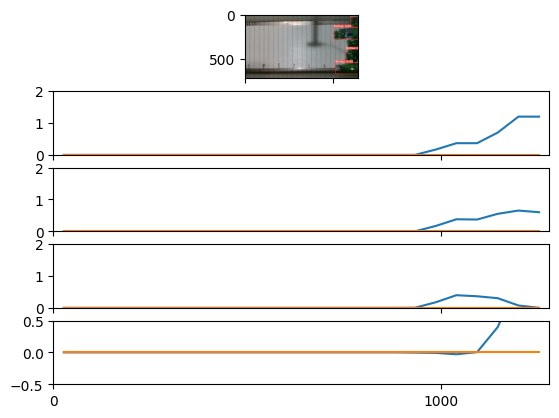

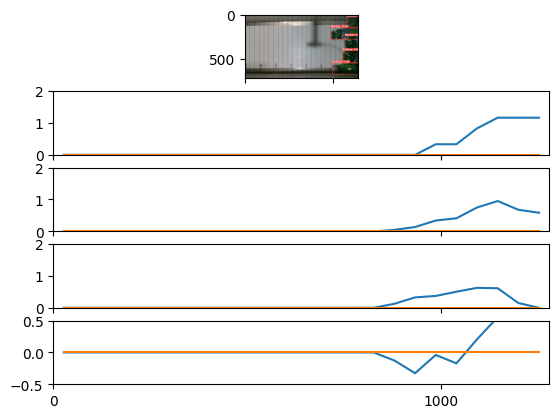

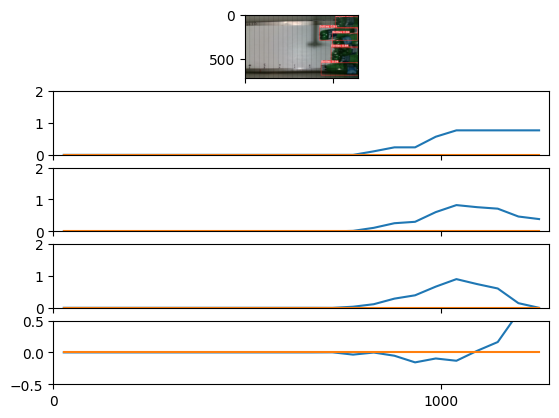

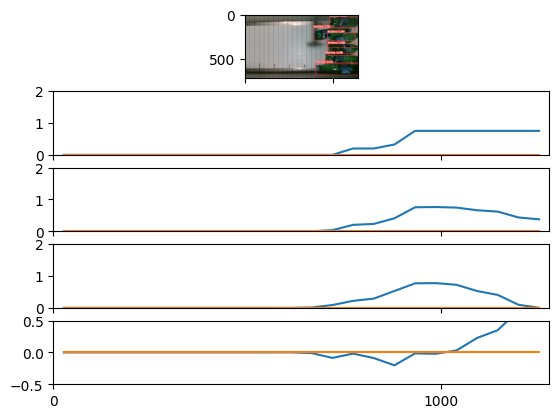

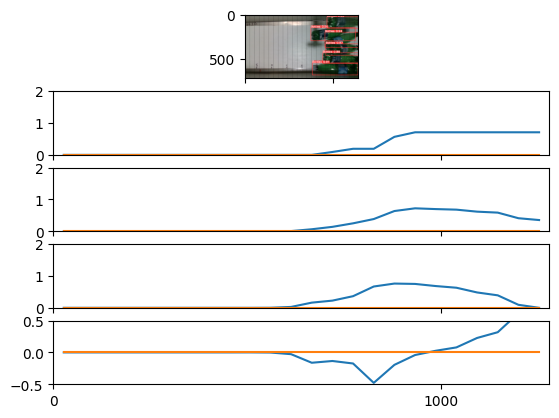

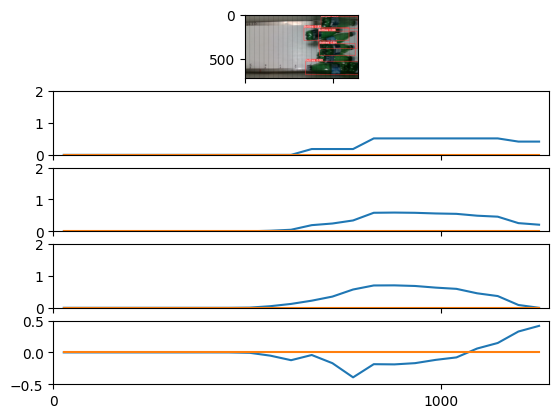

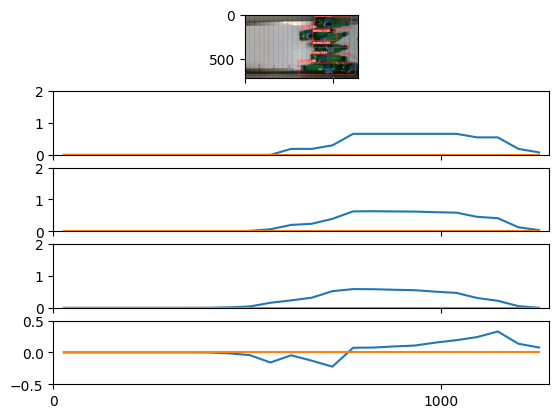

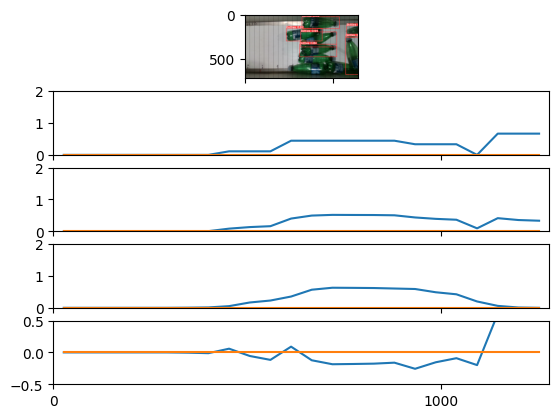

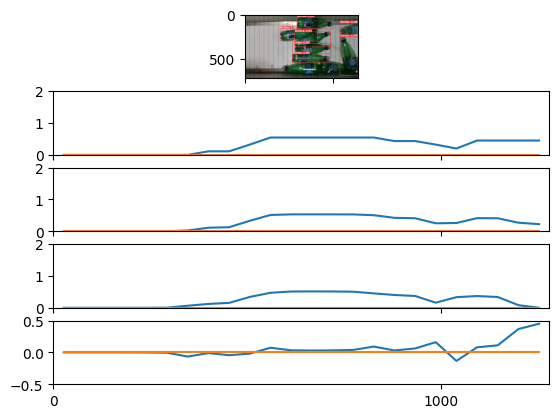

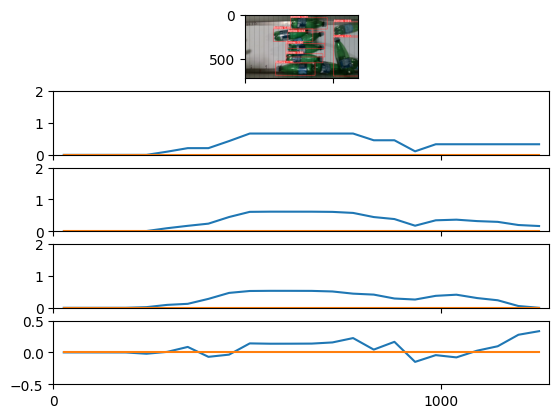

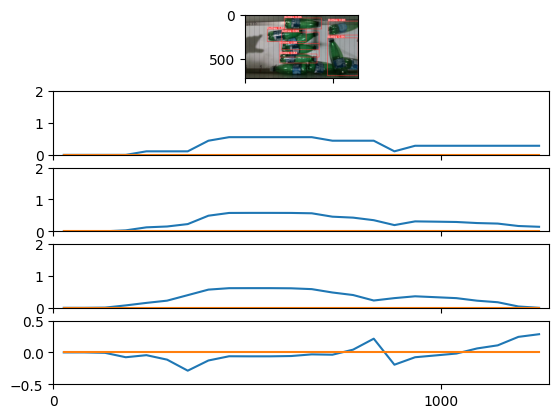

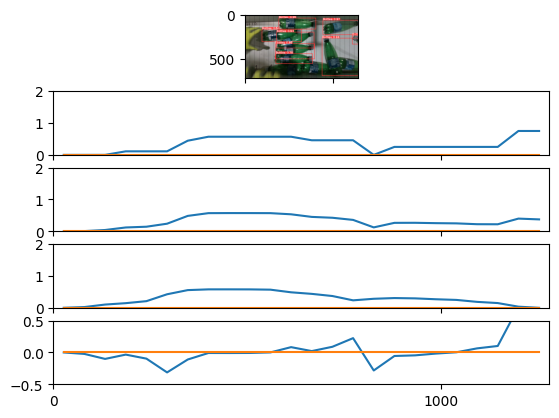

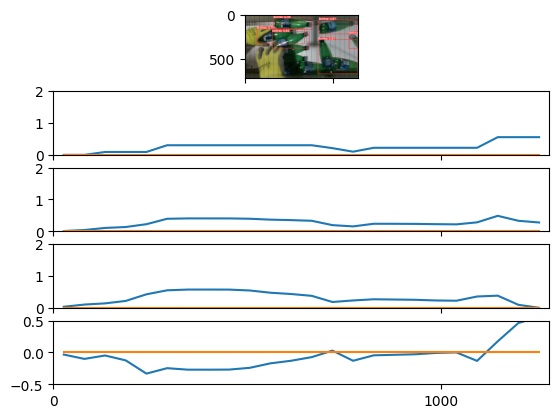

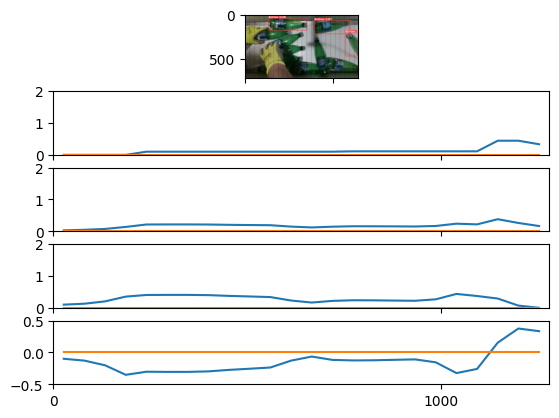

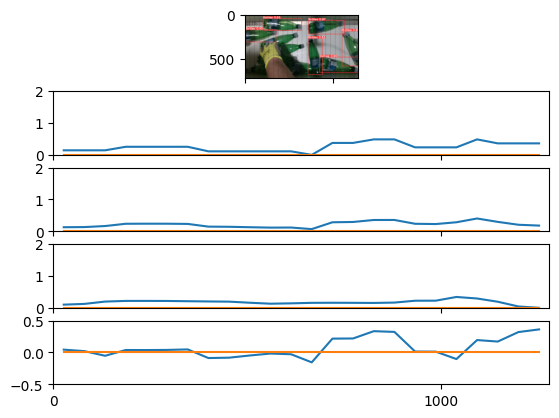

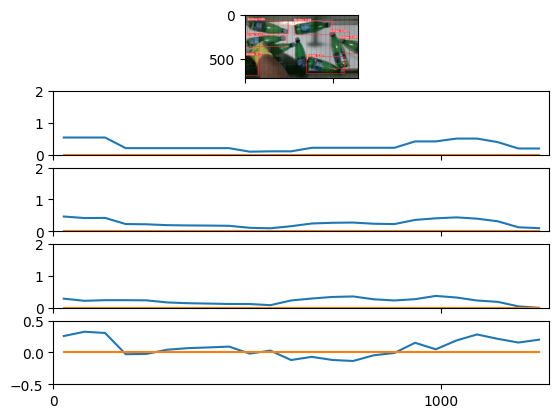

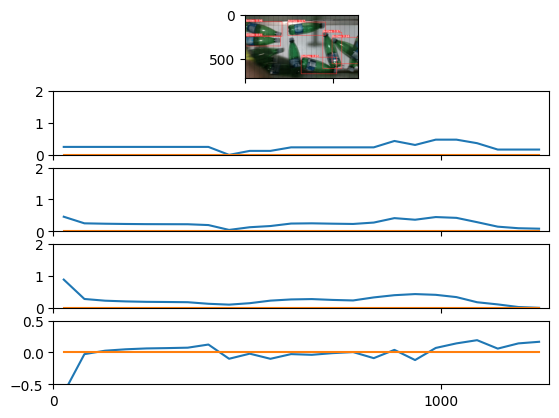

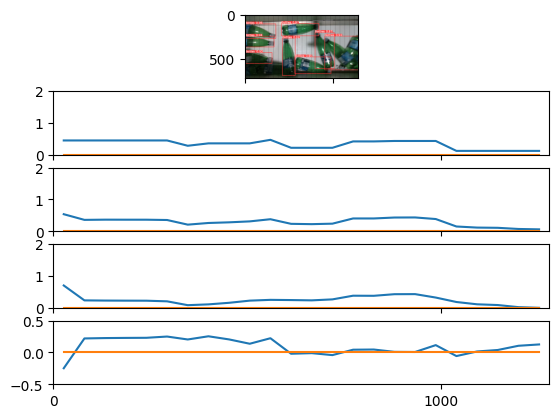

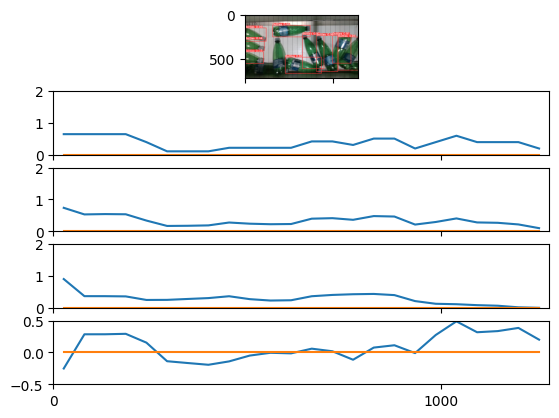

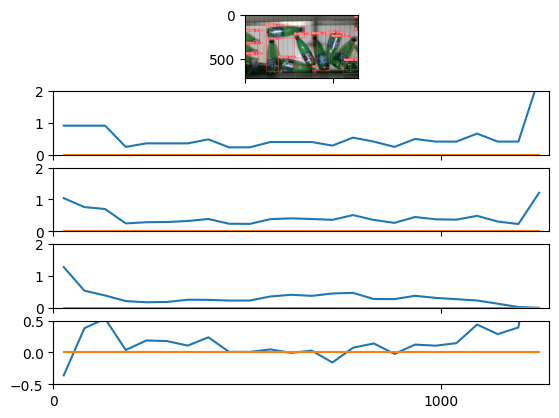

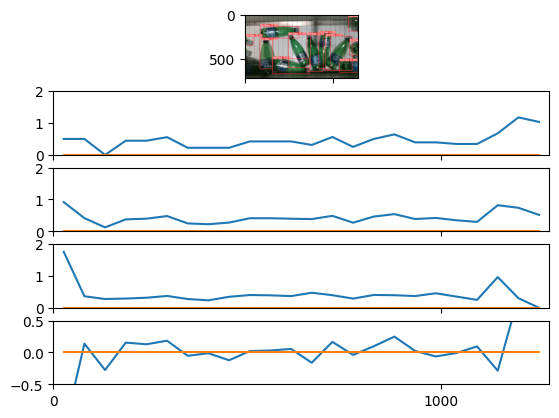

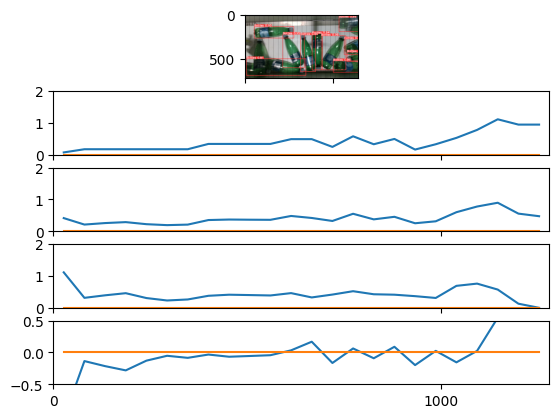

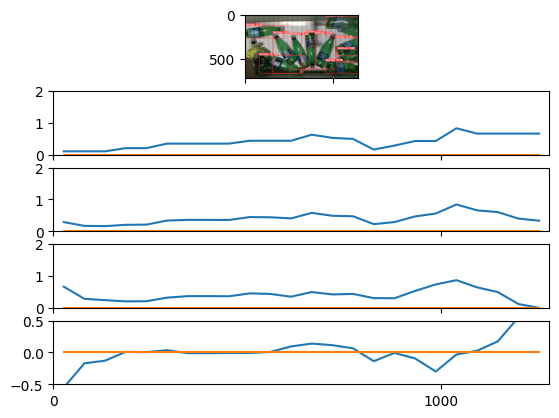

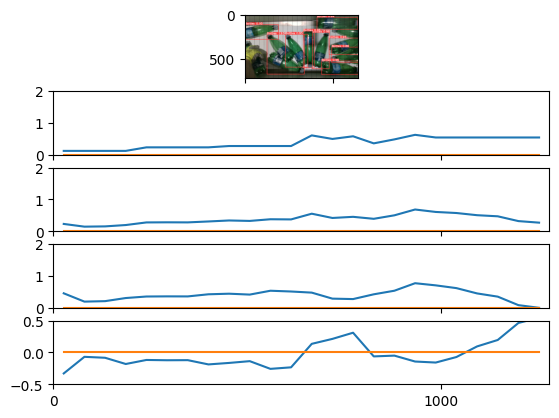

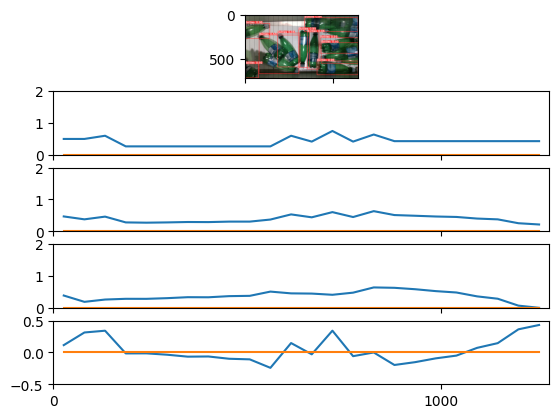

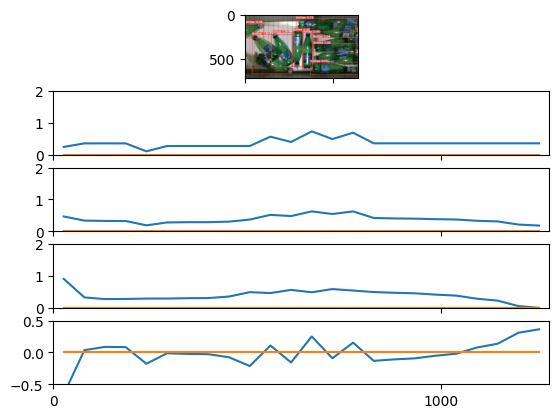

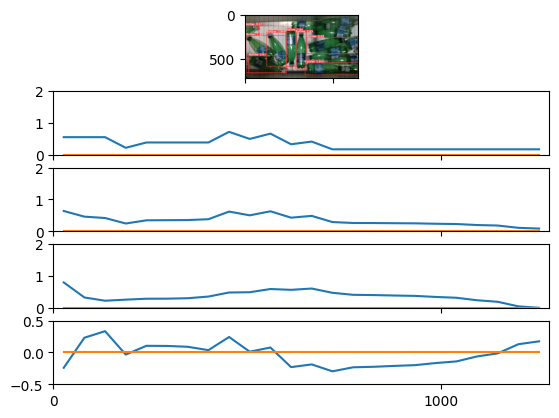

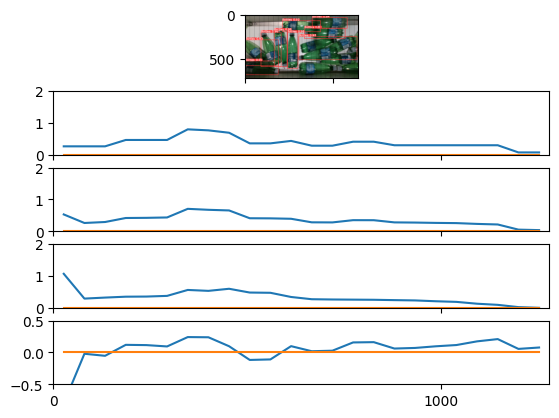

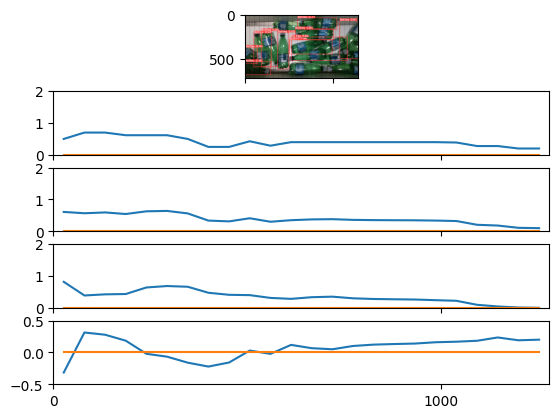

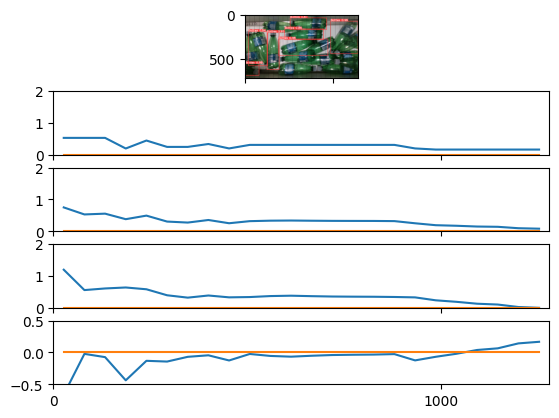

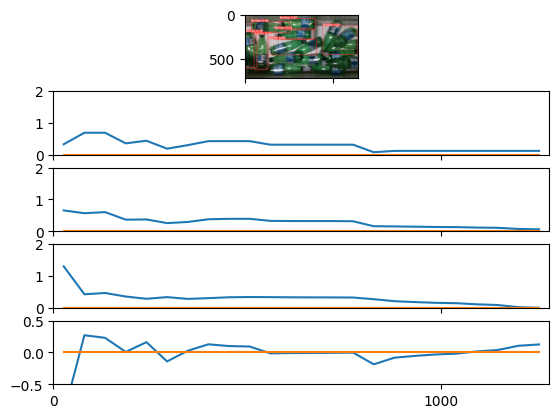

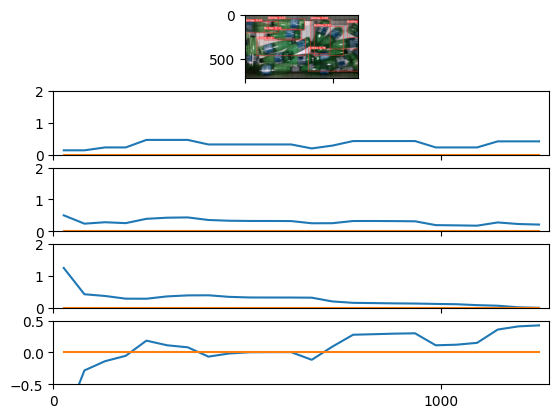

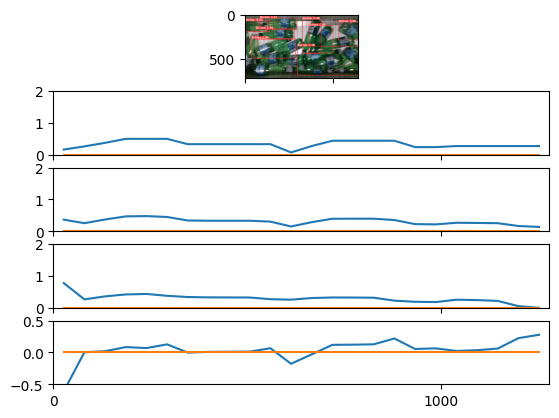

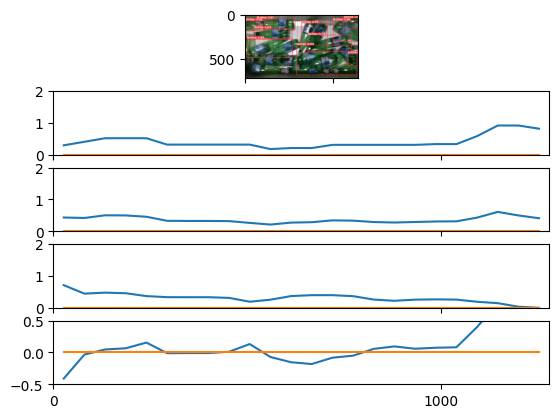

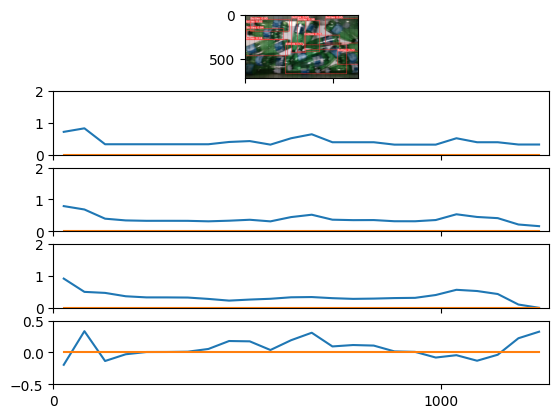

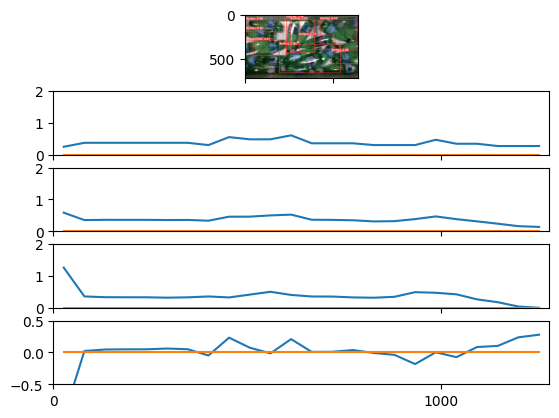

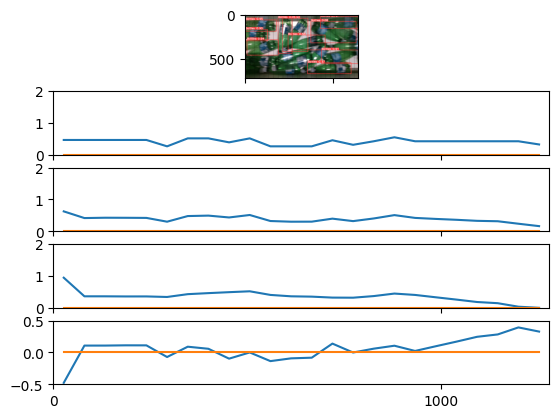

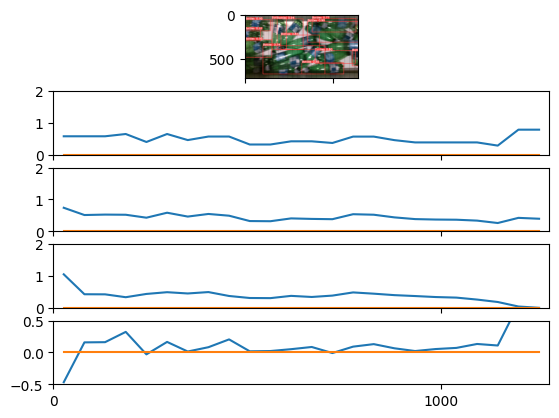

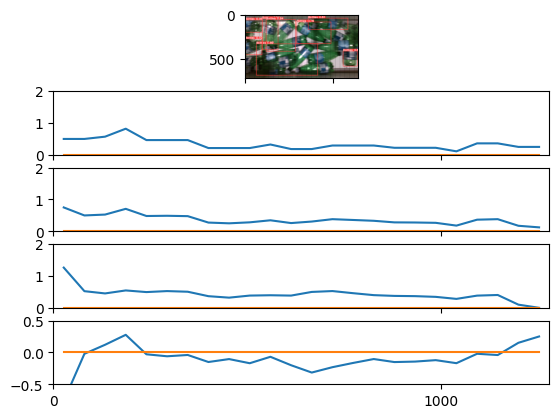

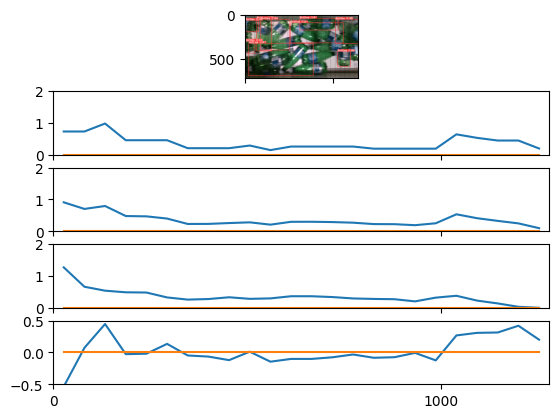

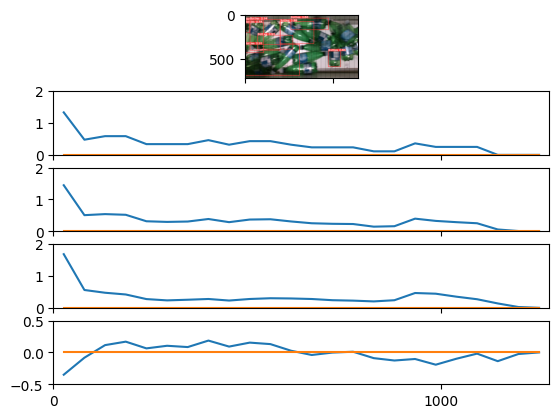

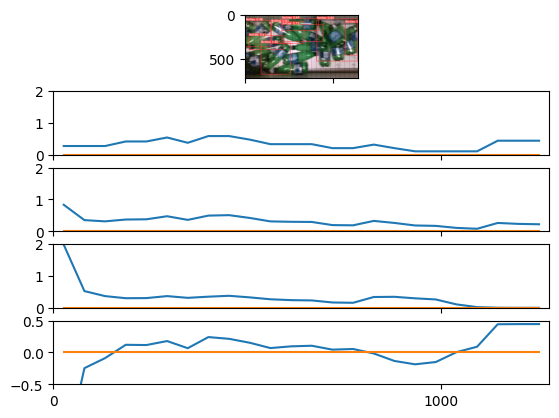

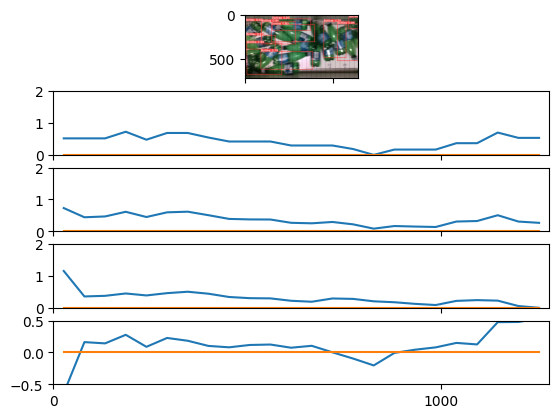

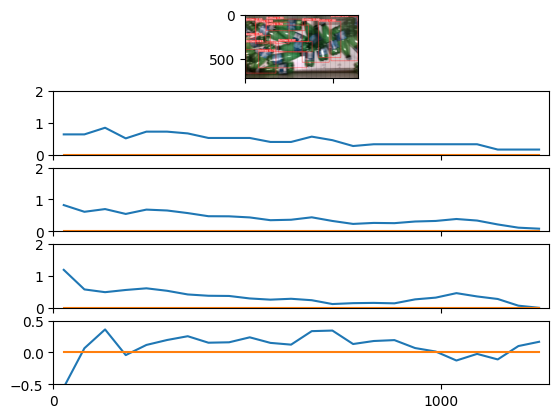

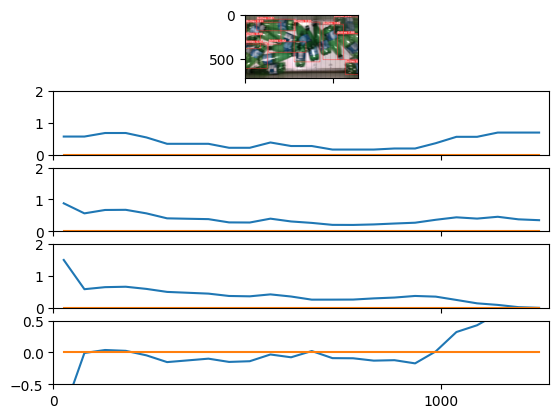

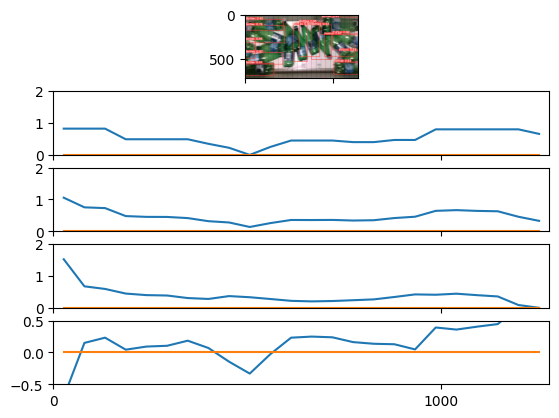

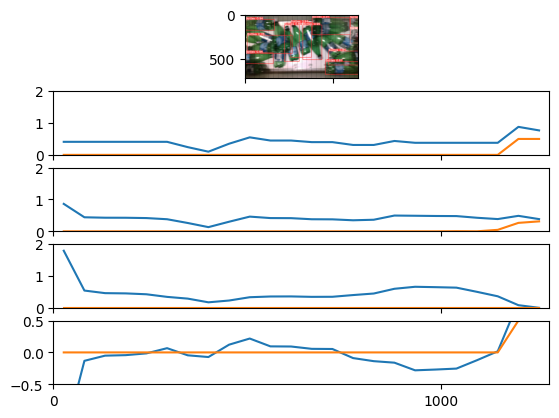

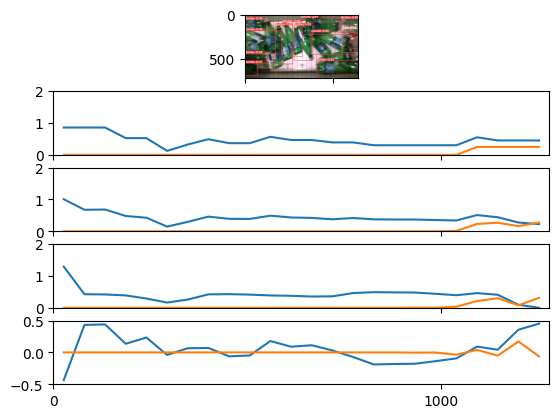

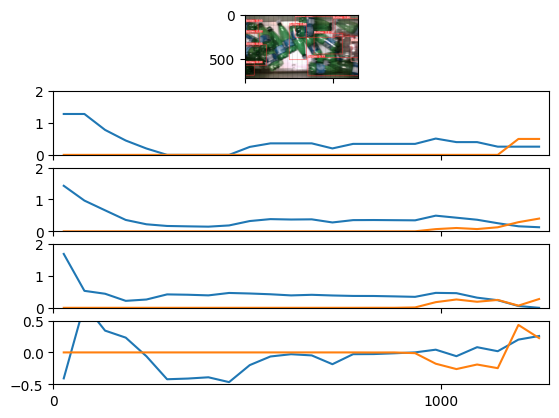

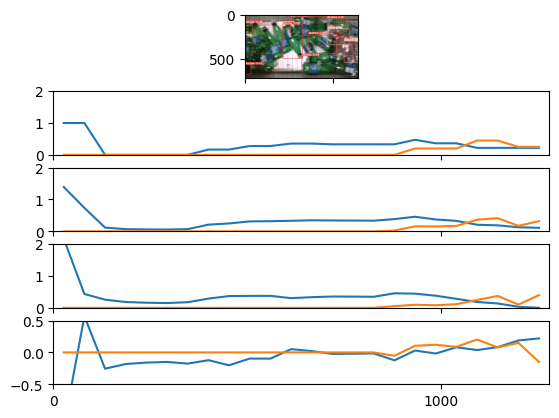

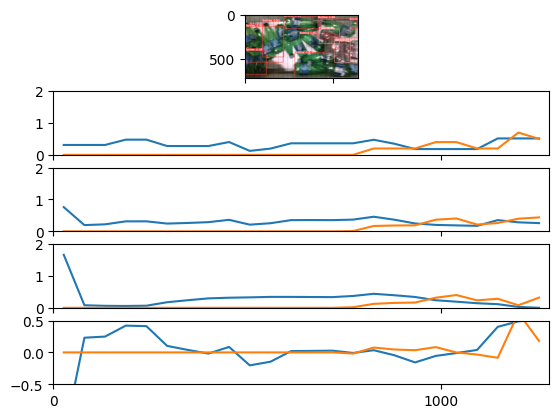

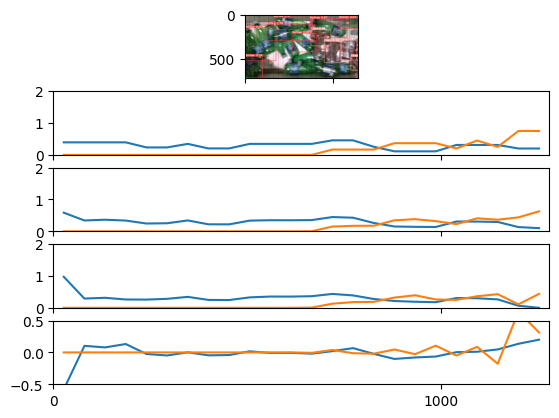

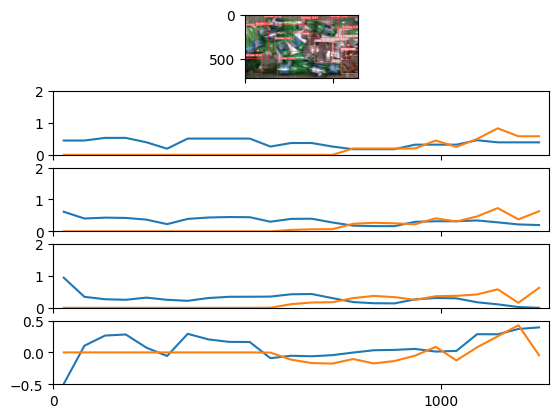

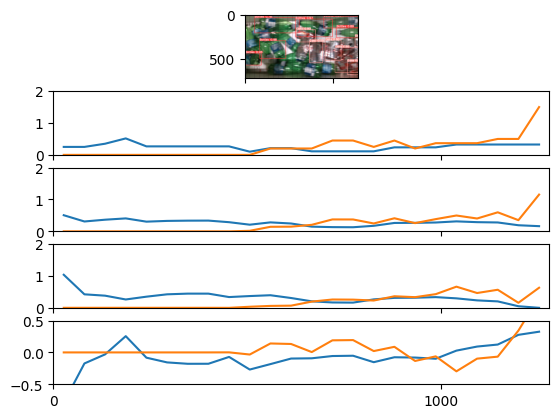

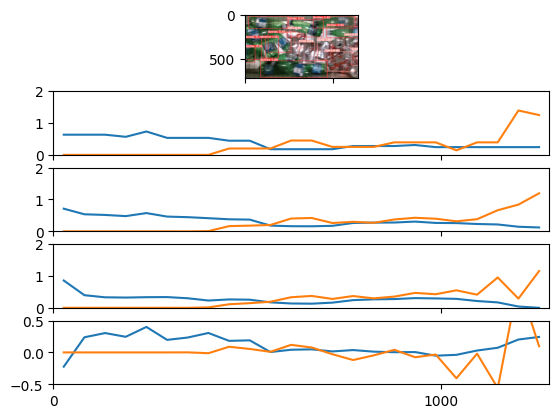

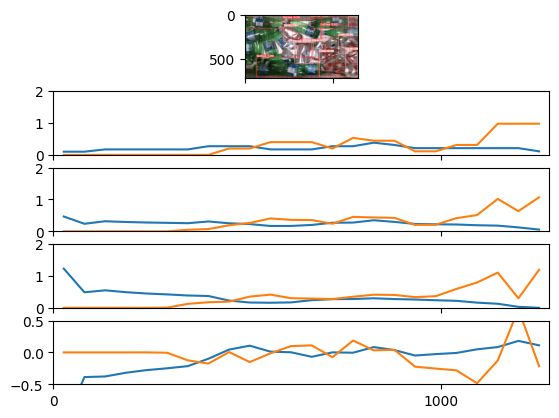

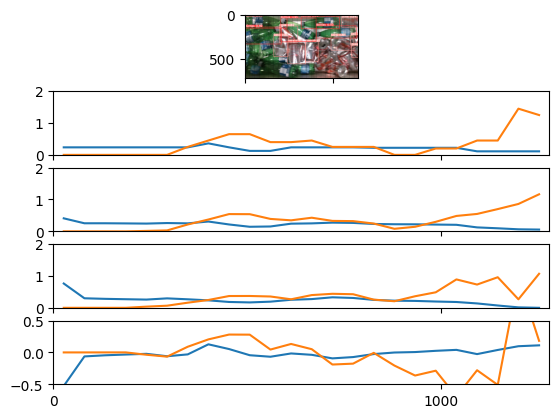

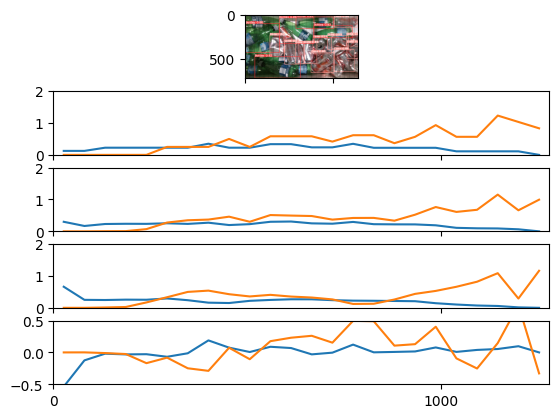

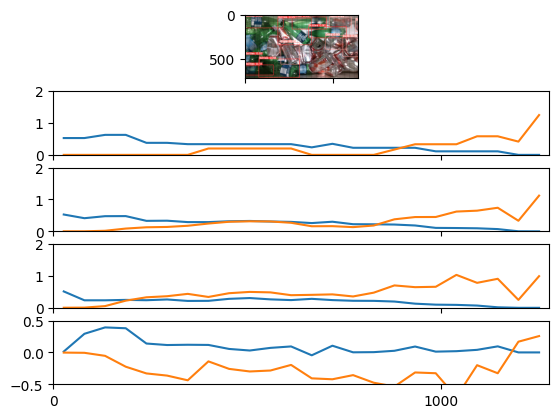

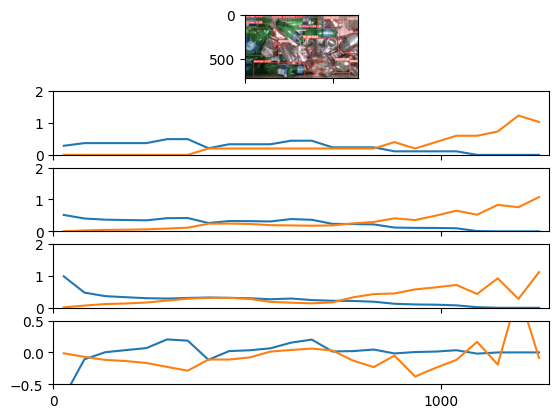

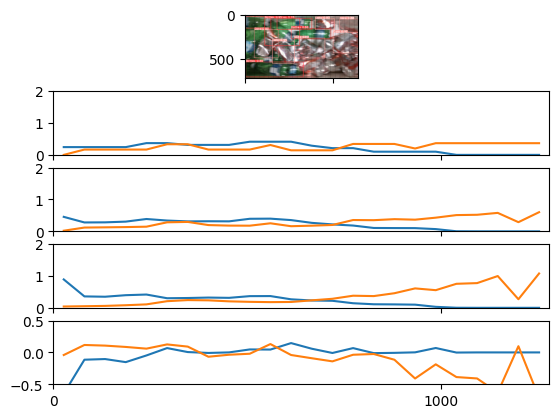

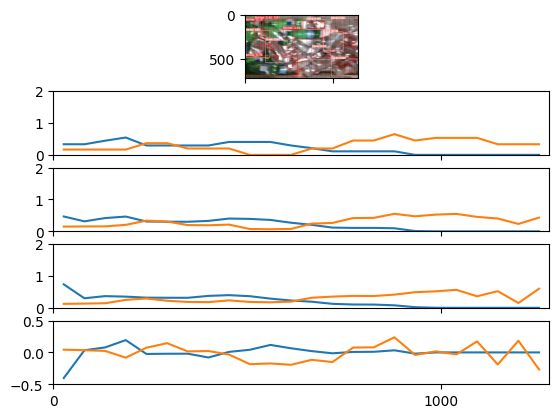

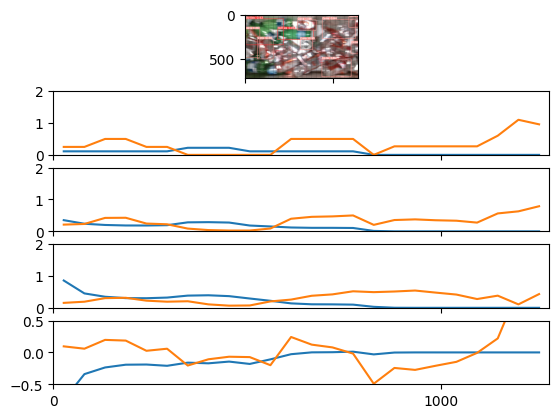

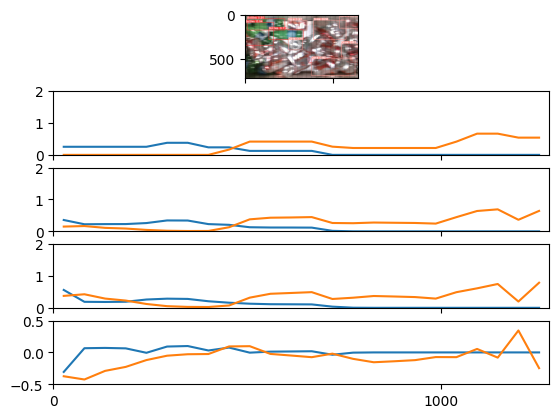

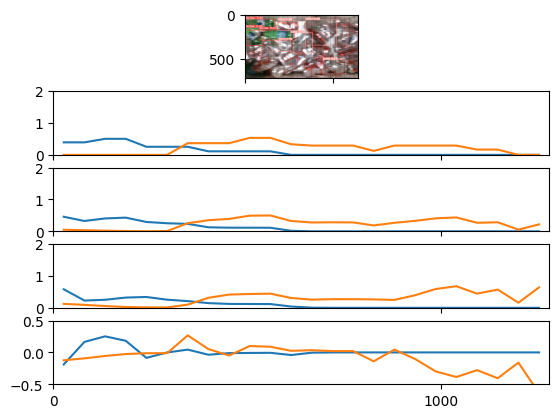

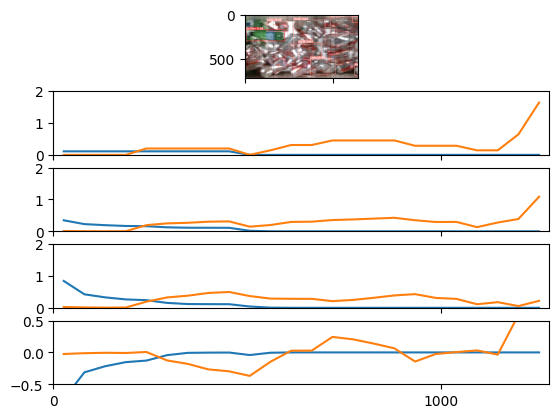

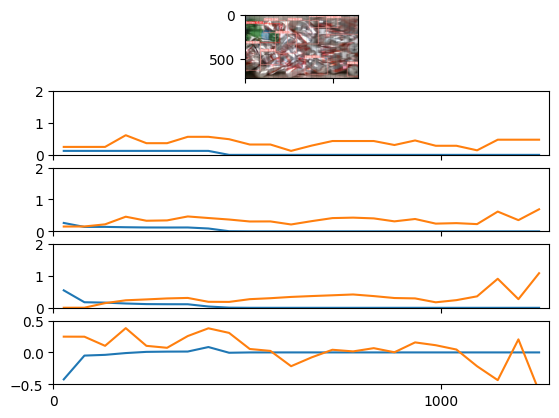

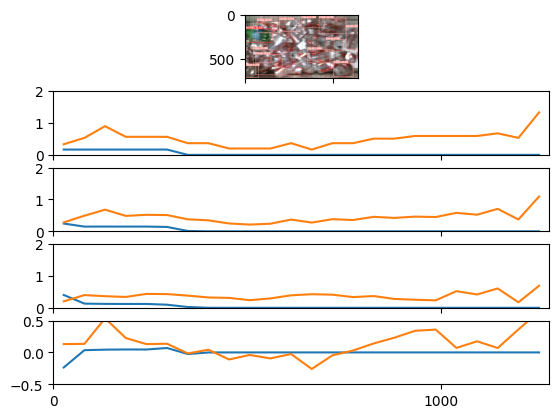

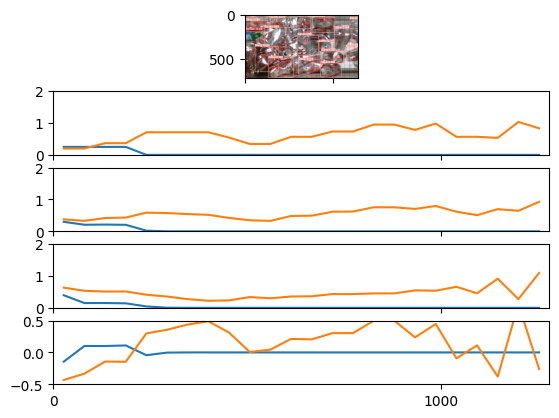

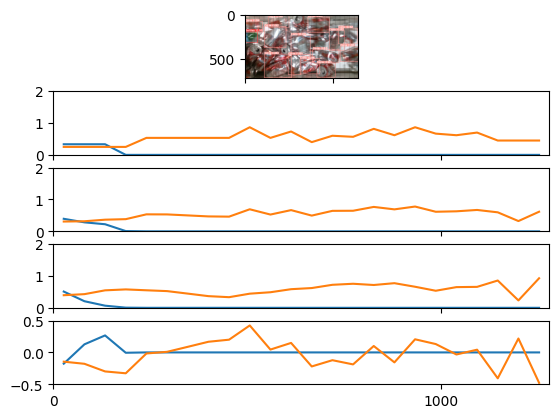

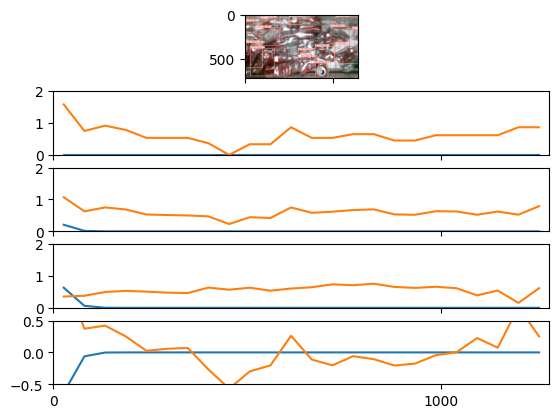

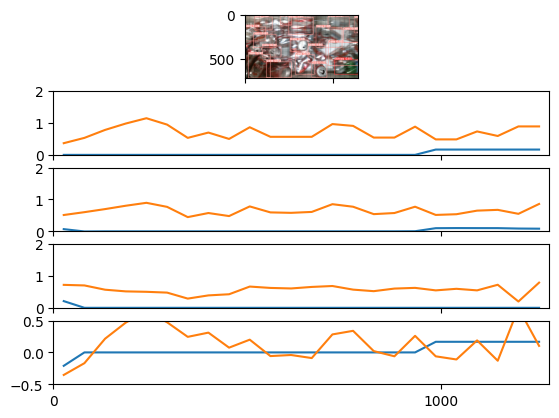

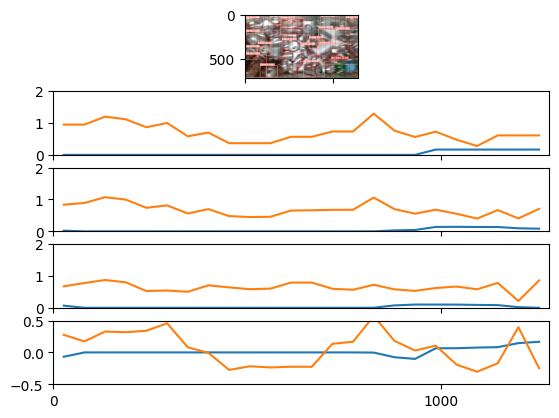

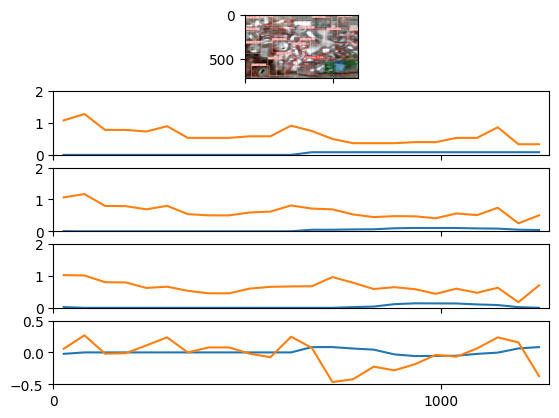

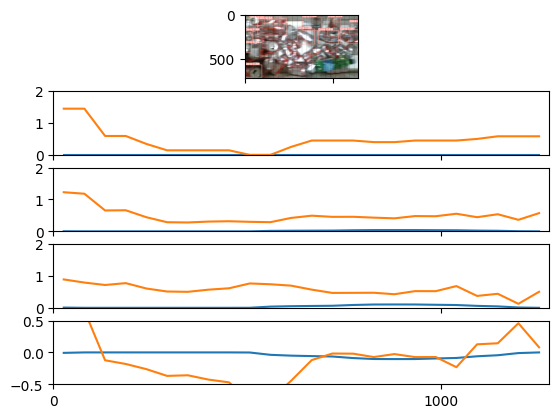

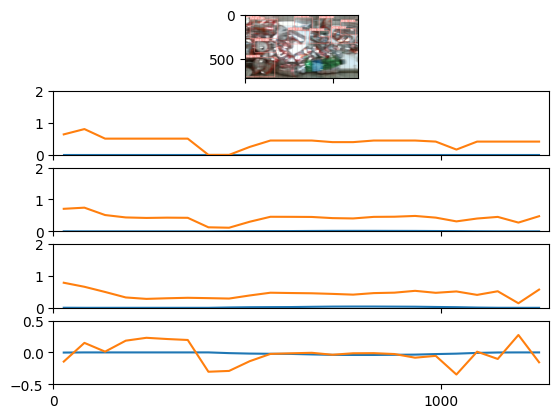

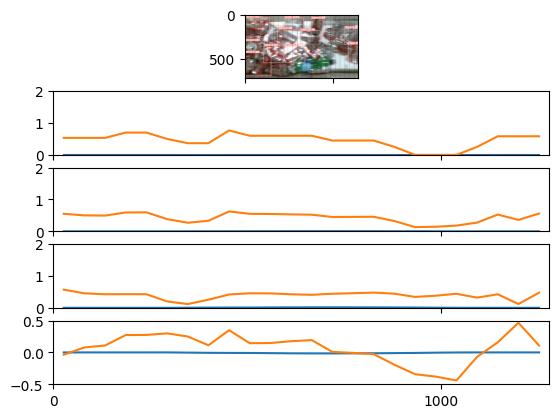

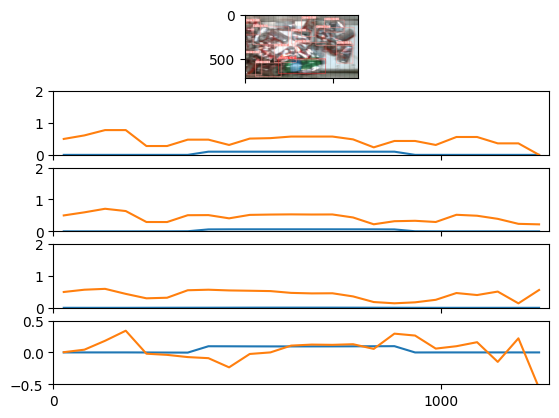

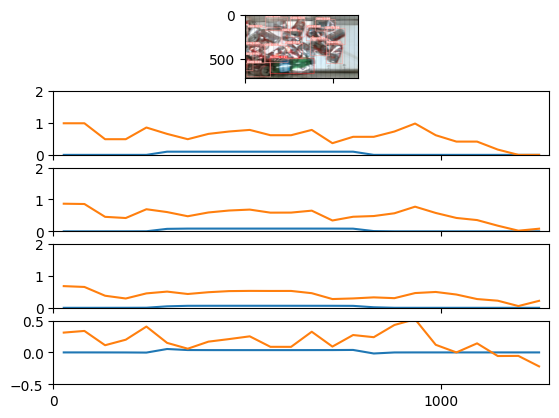

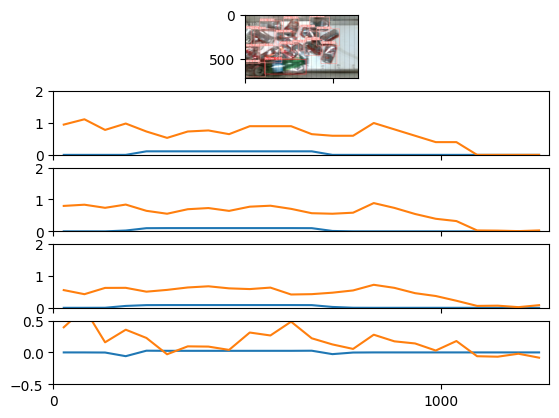

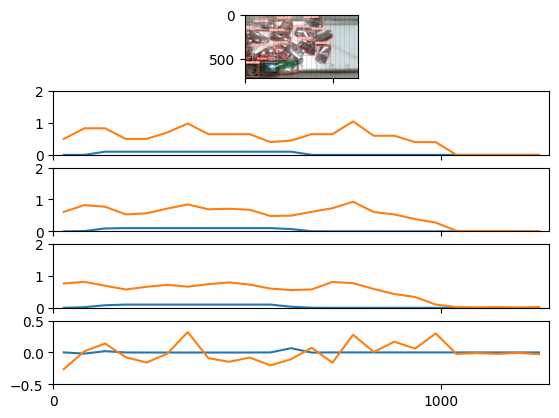

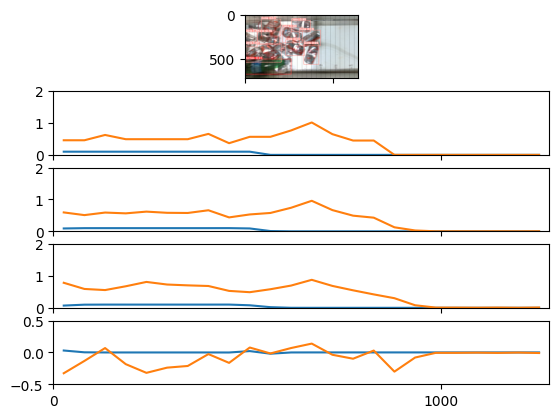

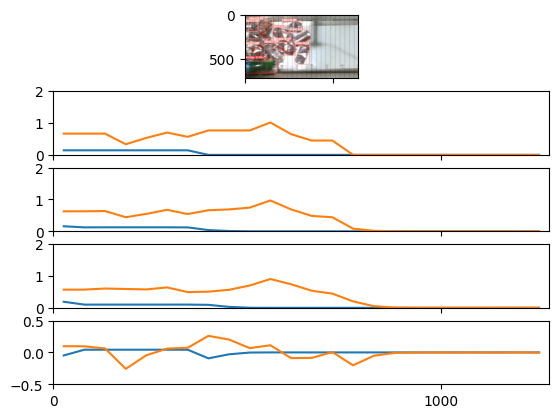

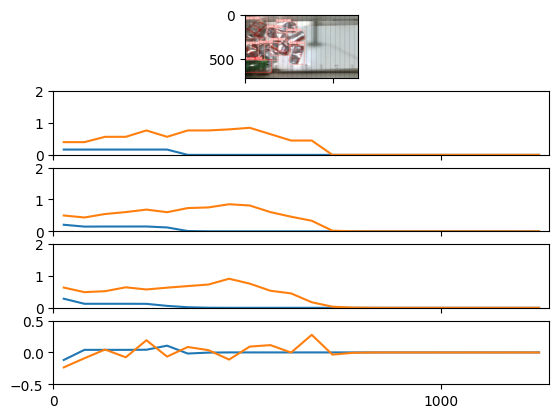

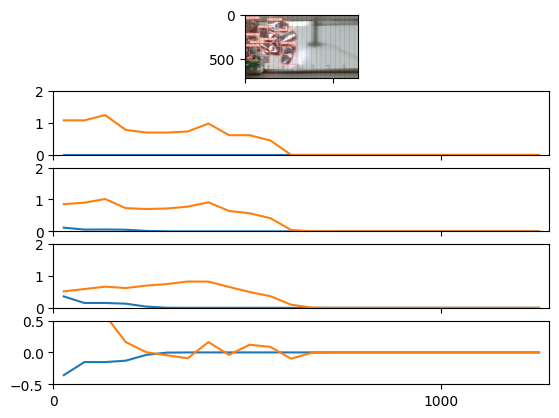

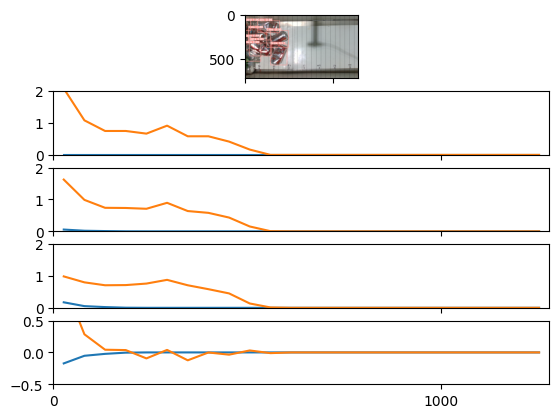

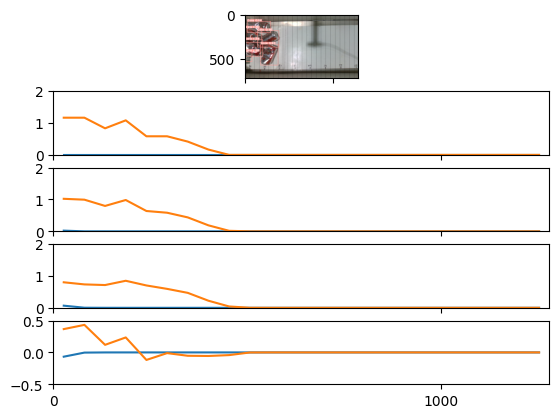

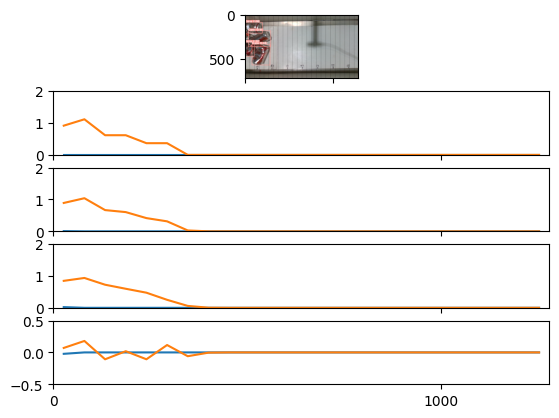

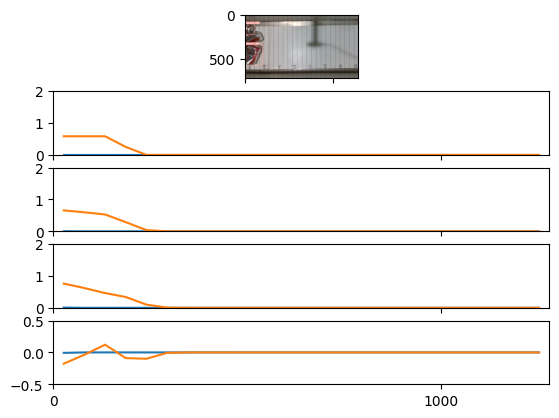

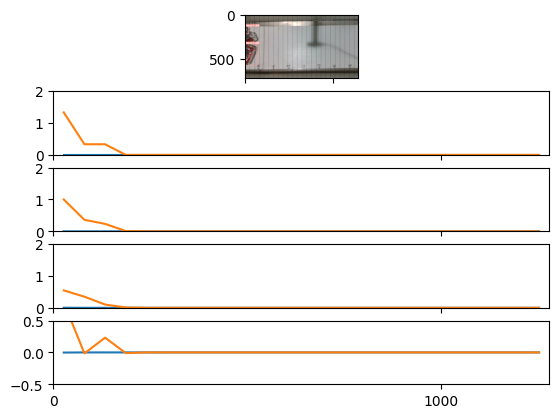

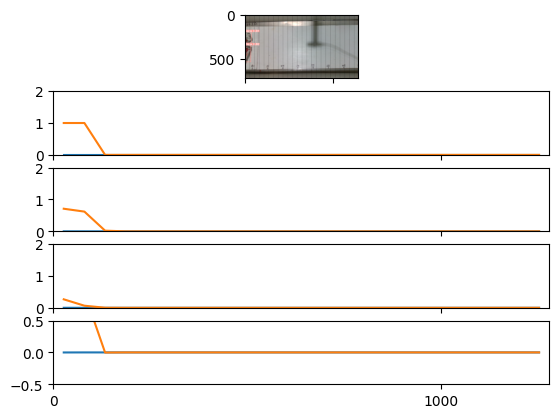

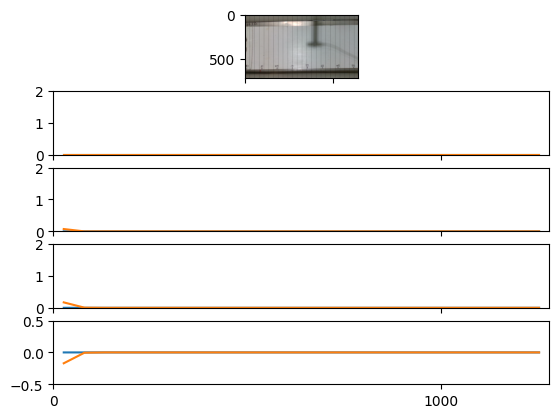

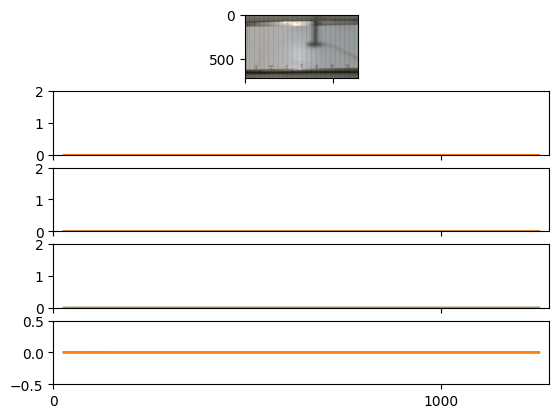

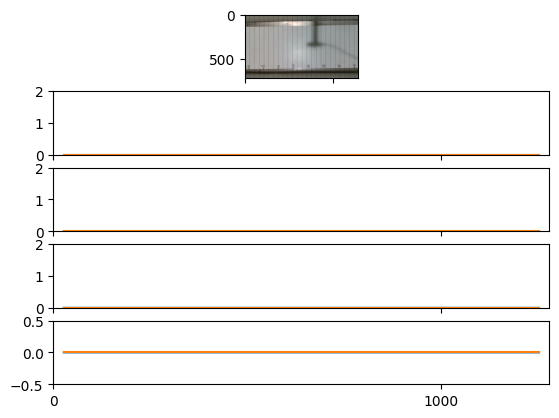

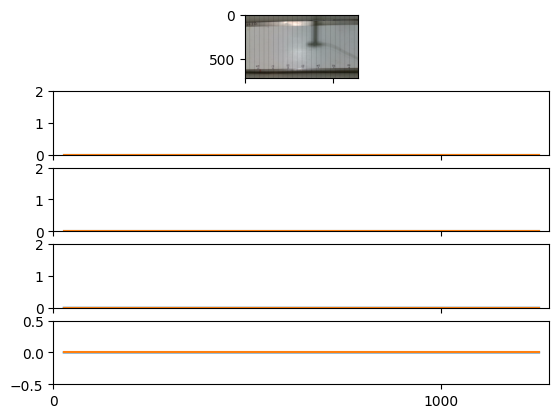

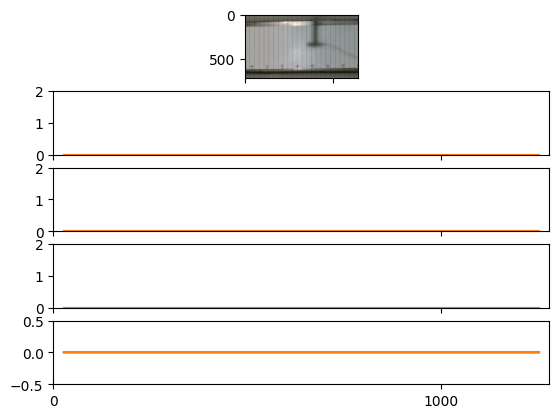

In [346]:
# for i in range(5):
for i in range(len(images)):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex='col')
    ax1.imshow(images[i]*im_mask)
    ax2.plot(vol_ids, states_disp[i][0])
    ax2.plot(vol_ids, states_disp[i][1])
    ax2.set_ylim(0, 2)
    
    ax3.plot(vol_ids, ests_disp[i][0])
    ax3.plot(vol_ids, ests_disp[i][1])
    ax3.set_ylim(0, 2)
    
    ax4.plot(vol_ids, preds_disp[i][0])
    ax4.plot(vol_ids, preds_disp[i][1])
    ax4.set_ylim(0, 2)
    
    ax5.plot(vol_ids, inn_disp[i][0])
    ax5.plot(vol_ids, inn_disp[i][1])
    ax5.set_ylim(-0.5, 0.5)
    name = 'plot_' + str(i)
    fig.savefig(name)
    # print(


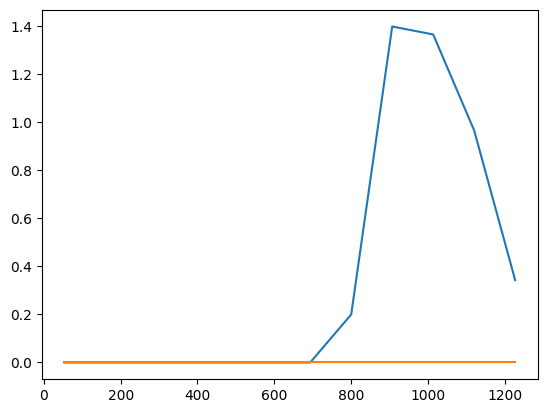

In [210]:
for i in range(len(images)):
    
    # ax1.imshow(images[i]*im_mask)
    ax2.plot(vol_ids, states_disp[i][0])
    ax2.plot(vol_ids, states_disp[i][1])
    ax2.set_ylim(0, 2)
    
    ax3.plot(vol_ids, ests_disp[i][0])
    ax3.plot(vol_ids, ests_disp[i][1])
    ax3.set_ylim(0, 2)
    
    ax4.plot(vol_ids, preds_disp[i][0])
    ax4.plot(vol_ids, preds_disp[i][1])
    ax4.set_ylim(0, 2)
    
    ax5.plot(vol_ids, inn_disp[i][0])
    ax5.plot(vol_ids, inn_disp[i][1])
    ax5.set_ylim(0, 2)
    name = 'plot_' + str(i)
    fig.savefig(name)
    # print(

In [275]:
%matplotlib inline

In [155]:
for i in range(3):
    print(i)

0
1
2
